# 1. DataFrame details

### The benefits for using Spark for data cleaning.
* Spark is able to process that millions or even billions of pieces of data. 
* Scale the data processing capacity as the requirements evolve. 
* Beyond the performance issues, dealing with large quantities of data requires a process, or pipeline of steps. Spark allows management of many complex tasks within a single framework.
* Spark offers high performance.
* Spark allows orderly data flows.
* Spark can use strictly defined schemas while ingesting data.

## Defining a schema
Creating a defined schema helps with data quality and import performance. 

In [2]:
# Import the pyspark.sql.types library
from pyspark.sql.types import *

# Define a new schema using the StructType method
people_schema = StructType([
  # Define a StructField for each field
  StructField('name', StringType(), False),
  StructField('age', IntegerType(), True),
  StructField('city', StringType(), True)
])

### Immutability and lazy processing
* Spark is designed to use immutable objects. Practically, this means Spark Data Frames are defined once and are not modifiable after initialization. If the variable name is reused, the original data is removed (assuming it's not in use elsewhere) and the variable name is reassigned to the new data. While this seems inefficient, it actually allows Spark to share data between all cluster components. It can do so without worry about concurrent data objects.<br>
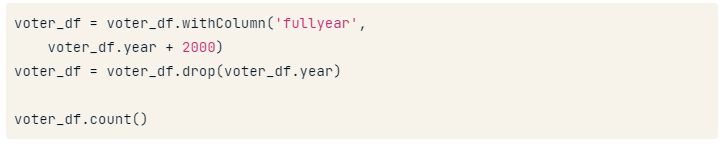<br>
Please note that the original year column is now permanently gone from this instance, though not from the underlying data.<br><br>
* Lazy processing in Spark is the idea that very little actually happens until an action is performed. In our previous example, we read a CSV file, added a new column, and deleted another. The trick is that no data was actually read / added / modified, we only updated the instructions (aka, Transformations) for what we wanted Spark to do. This functionality allows Spark to perform the most efficient set of operations to get the desired result. 

The code example is the same as the previous slide, but with the added count() method call. This classifies as an action in Spark and will process all the transformation operations.

## Using lazy processing


In [1]:
# Import pyspark.sql.functions as F
import pyspark.sql.functions as F

# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession 

# Create my_spark
spark = SparkSession.builder.getOrCreate()

# Print my_spark
print(spark)

In [6]:
# Load the CSV file
aa_dfw_df = spark.read.format('csv').options(Header=True).load('AA_DFW_2017_Departures_Short.csv.gz')

# Add the airport column using the F.lower() method
aa_dfw_df = aa_dfw_df.withColumn('airport', F.lower(aa_dfw_df['Destination Airport']))

# Drop the Destination Airport column
aa_dfw_df = aa_dfw_df.drop(aa_dfw_df['Destination Airport'])

# Show the DataFrame
aa_dfw_df.show()

+-----------------+-------------+-----------------------------+-------+
|Date (MM/DD/YYYY)|Flight Number|Actual elapsed time (Minutes)|airport|
+-----------------+-------------+-----------------------------+-------+
|       01/01/2017|         0005|                          537|    hnl|
|       01/01/2017|         0007|                          498|    ogg|
|       01/01/2017|         0037|                          241|    sfo|
|       01/01/2017|         0043|                          134|    dtw|
|       01/01/2017|         0051|                           88|    stl|
|       01/01/2017|         0060|                          149|    mia|
|       01/01/2017|         0071|                          203|    lax|
|       01/01/2017|         0074|                           76|    mem|
|       01/01/2017|         0081|                          123|    den|
|       01/01/2017|         0089|                          161|    slc|
|       01/01/2017|         0096|                           84| 

## Understanding Parquet
### The Parquet Format
* columnar data format 
* supported in spark and other data processing frameworks
* supports predicate pushdown
* automatically stores schema information 
* binary file format <br>
`predicate pushdown` This means Spark will only process the data necessary to complete the operations you define versus reading the entire dataset.<br>
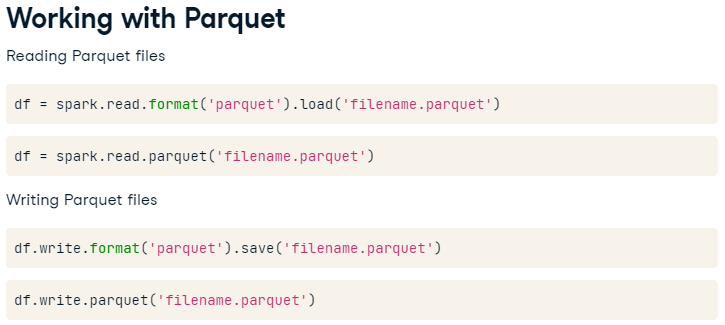

In [38]:
# Load the CSV file
df1 = spark.read.format('csv').options(Header=True).load('AA_DFW_2014_Departures_Short.csv.gz')
# Rename the column
df1 = df1.withColumnRenamed("Date (MM/DD/YYYY)", "Date")
df1 = df1.withColumnRenamed("Flight Number", "Flight_Number")
df1 = df1.withColumnRenamed("Destination Airport", "Destination_Airport")
df1 = df1.withColumnRenamed("Actual elapsed time (Minutes)", "flight_duration")

# Load the CSV file
df2 = spark.read.format('csv').options(Header=True).load('AA_DFW_2015_Departures_Short.csv.gz')
# Rename the Date (MM/DD/YYYY) column
df2 = df2.toDF("Date","Flight_Number","Destination_Airport","flight_duration")

#### 2 way to rename the multiple columns ^^^

## Saving a DataFrame in Parquet format

In [39]:
# View the row count of df1 and df2
print("df1 Count: %d" % df1.count())
print("df2 Count: %d" % df2.count())

# Combine the DataFrames into one
df3 = df1.union(df2)

# Save the df3 DataFrame in Parquet format
df3.write.parquet('AA_DFW_ALL.parquet', mode='overwrite')

# Read the Parquet file into a new DataFrame and run a count
print(spark.read.parquet('AA_DFW_ALL.parquet').count())

df1 Count: 157198
df2 Count: 146558
303756


## SQL and Parquet
Parquet files are perfect as a backing data store for SQL queries in Spark. While it is possible to run the same queries directly via Spark's Python functions, sometimes it's easier to run SQL queries alongside the Python options.!<br>
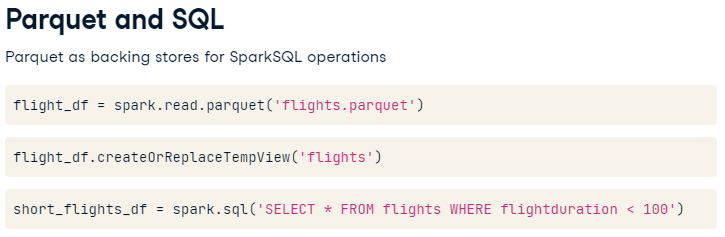

In [40]:
# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession 

In [42]:
# Read the Parquet file into flights_df
flights_df = spark.read.parquet('AA_DFW_ALL.parquet')

# Register the temp table
flights_df.createOrReplaceTempView('flights')

# Run a SQL query of the average flight duration
avg_duration = spark.sql('SELECT avg(flight_duration) from flights').collect()[0]
print('The average flight time is: %d' % avg_duration)

The average flight time is: 143


# 2. Manipulating DataFrames in the real world

## DataFrame column operations
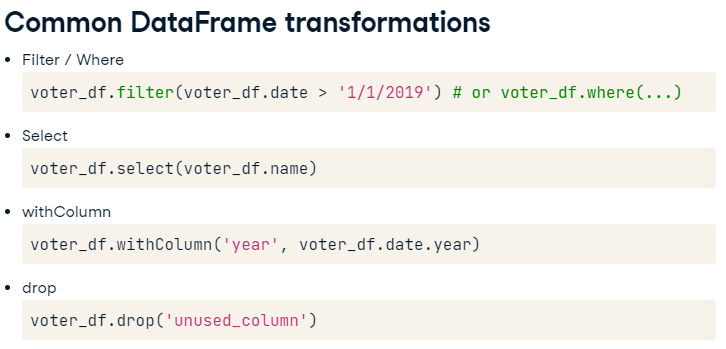

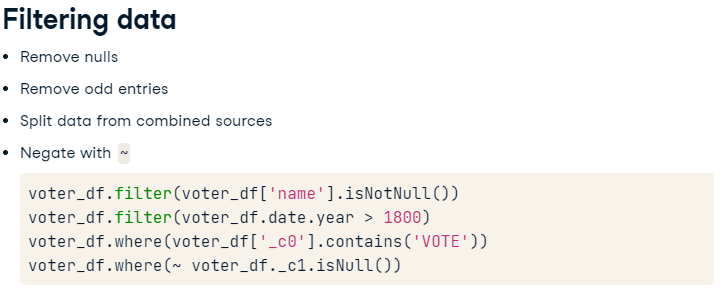

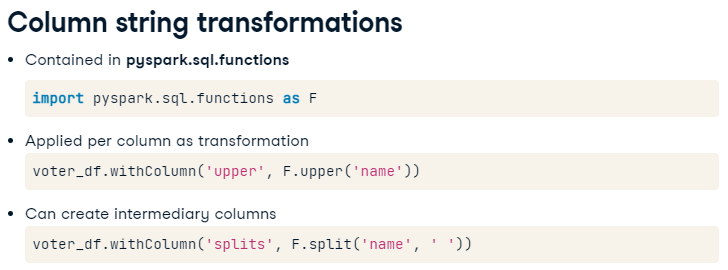

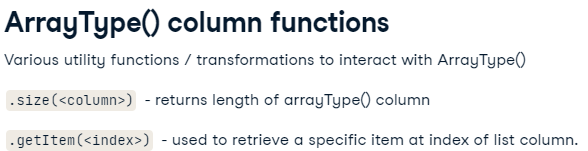

## Filtering column content with Python
The DataFrame voter_df contains information regarding the voters on the Dallas City Council from the past few years. This truncated DataFrame contains the date of the vote being cast and the name and position of the voter. 
* This is often one of the first steps in data cleaning - removing anything that is obviously outside the format. 

In [7]:
# Load the CSV file
voter_df = spark.read.format('csv').options(Header=True).load('DallasCouncilVoters.csv.gz')

In [8]:
# Show the distinct VOTER_NAME entries
voter_df.select('VOTER_NAME').distinct().show(40, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|VOTER_NAME                                                                                                                                                                                                                                                                                                                                                                                                                 |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [9]:
# Filter voter_df where the VOTER_NAME is 1-20 characters in length
voter_df = voter_df.filter('length(VOTER_NAME) > 0 and length(VOTER_NAME) < 20')

# Filter out voter_df where the VOTER_NAME contains an underscore
voter_df = voter_df.filter(~ F.col('VOTER_NAME').contains('_'))

# Show the distinct VOTER_NAME entries again
voter_df.select('VOTER_NAME').distinct().show(40, truncate=False)

+-------------------+
|VOTER_NAME         |
+-------------------+
|Tennell Atkins     |
|Scott Griggs       |
|Scott  Griggs      |
|Sandy Greyson      |
|Michael S. Rawlings|
|Kevin Felder       |
|Adam Medrano       |
|Casey  Thomas      |
|Mark  Clayton      |
|Casey Thomas       |
|Sandy  Greyson     |
|Mark Clayton       |
|Jennifer S.  Gates |
|Tiffinni A. Young  |
|B. Adam  McGough   |
|Omar Narvaez       |
|Philip T. Kingston |
|Rickey D. Callahan |
|Dwaine R. Caraway  |
|Philip T.  Kingston|
|Jennifer S. Gates  |
|Lee M. Kleinman    |
|Monica R. Alonzo   |
|Rickey D.  Callahan|
|Carolyn King Arnold|
|Erik Wilson        |
|Lee Kleinman       |
+-------------------+



## Modifying DataFrame columns
Based on your earlier work, then you need to create two new columns - first_name and last_name. 
* split the VOTER_NAME column into words on any space character. 
* treat the last word as the last_name, and all other words as the first_name. 
* You'll be using some new functions in this exercise including `.split()`, `.size()`, and `.getItem()`. The `.getItem(index)` takes an integer value to return the appropriately numbered item in the column. 

In [13]:
# Add a new column called splits separated on whitespace
voter_df = voter_df.withColumn("splits", F.split(voter_df.VOTER_NAME, '\s+'))

# Show the splits Column
voter_df.select("splits").show()

+--------------------+
|              splits|
+--------------------+
|[Jennifer, S., Ga...|
|[Philip, T., King...|
|[Michael, S., Raw...|
|     [Adam, Medrano]|
|     [Casey, Thomas]|
|[Carolyn, King, A...|
|     [Scott, Griggs]|
| [B., Adam, McGough]|
|     [Lee, Kleinman]|
|    [Sandy, Greyson]|
|[Jennifer, S., Ga...|
|[Philip, T., King...|
|[Michael, S., Raw...|
|     [Adam, Medrano]|
|     [Casey, Thomas]|
|[Carolyn, King, A...|
|[Rickey, D., Call...|
|[Jennifer, S., Ga...|
|    [Sandy, Greyson]|
|[Jennifer, S., Ga...|
+--------------------+
only showing top 20 rows



In [14]:
# Create a new column called first_name based on the first item in splits
voter_df = voter_df.withColumn("first_name", voter_df.splits.getItem(0))

# Show the first_name Column
voter_df.select("first_name").show()

+----------+
|first_name|
+----------+
|  Jennifer|
|    Philip|
|   Michael|
|      Adam|
|     Casey|
|   Carolyn|
|     Scott|
|        B.|
|       Lee|
|     Sandy|
|  Jennifer|
|    Philip|
|   Michael|
|      Adam|
|     Casey|
|   Carolyn|
|    Rickey|
|  Jennifer|
|     Sandy|
|  Jennifer|
+----------+
only showing top 20 rows



In [15]:
# Get the last entry of the splits list and create a column called last_name
voter_df = voter_df.withColumn("last_name", voter_df.splits.getItem(F.size('splits') - 1))

# Show the last_name Column
voter_df.select("last_name").show()

+---------+
|last_name|
+---------+
|    Gates|
| Kingston|
| Rawlings|
|  Medrano|
|   Thomas|
|   Arnold|
|   Griggs|
|  McGough|
| Kleinman|
|  Greyson|
|    Gates|
| Kingston|
| Rawlings|
|  Medrano|
|   Thomas|
|   Arnold|
| Callahan|
|    Gates|
|  Greyson|
|    Gates|
+---------+
only showing top 20 rows



In [16]:
# Drop the splits column
voter_df = voter_df.drop('splits')

# Show the voter_df DataFrame
voter_df.show()

+----------+-------------+-------------------+----------+---------+
|      DATE|        TITLE|         VOTER_NAME|first_name|last_name|
+----------+-------------+-------------------+----------+---------+
|02/08/2017|Councilmember|  Jennifer S. Gates|  Jennifer|    Gates|
|02/08/2017|Councilmember| Philip T. Kingston|    Philip| Kingston|
|02/08/2017|        Mayor|Michael S. Rawlings|   Michael| Rawlings|
|02/08/2017|Councilmember|       Adam Medrano|      Adam|  Medrano|
|02/08/2017|Councilmember|       Casey Thomas|     Casey|   Thomas|
|02/08/2017|Councilmember|Carolyn King Arnold|   Carolyn|   Arnold|
|02/08/2017|Councilmember|       Scott Griggs|     Scott|   Griggs|
|02/08/2017|Councilmember|   B. Adam  McGough|        B.|  McGough|
|02/08/2017|Councilmember|       Lee Kleinman|       Lee| Kleinman|
|02/08/2017|Councilmember|      Sandy Greyson|     Sandy|  Greyson|
|02/08/2017|Councilmember|  Jennifer S. Gates|  Jennifer|    Gates|
|02/08/2017|Councilmember| Philip T. Kingston|  

## Conditional DataFrame column operations
Conditional Clauses are:
* Inline version of if/then/elsse
* `.when()`
* `.otherwise()`

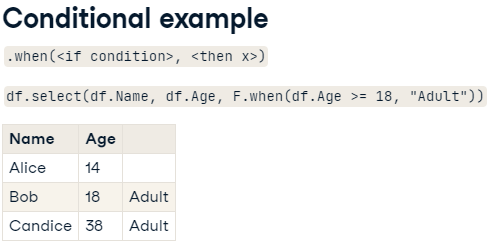

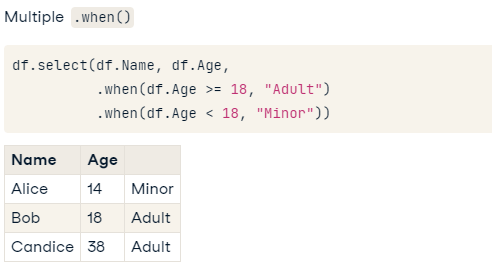

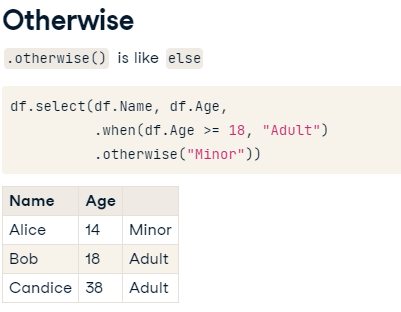

## when() example
* Modify our voter_df DataFrame to add a random number to any voting member that is defined as a "Councilmember". <br>
`F.rand()` to generate the random value.

In [17]:
# Add a column to voter_df for any voter with the title **Councilmember**
voter_df = voter_df.withColumn('random_val',
                               F.when(voter_df.TITLE == 'Councilmember', F.rand()))

# Show some of the DataFrame rows, noting whether the when clause worked
voter_df.show()

+----------+-------------+-------------------+----------+---------+--------------------+
|      DATE|        TITLE|         VOTER_NAME|first_name|last_name|          random_val|
+----------+-------------+-------------------+----------+---------+--------------------+
|02/08/2017|Councilmember|  Jennifer S. Gates|  Jennifer|    Gates| 0.48558767842760886|
|02/08/2017|Councilmember| Philip T. Kingston|    Philip| Kingston|  0.4399648982543276|
|02/08/2017|        Mayor|Michael S. Rawlings|   Michael| Rawlings|                null|
|02/08/2017|Councilmember|       Adam Medrano|      Adam|  Medrano|  0.6308184468232085|
|02/08/2017|Councilmember|       Casey Thomas|     Casey|   Thomas|  0.5356976078063939|
|02/08/2017|Councilmember|Carolyn King Arnold|   Carolyn|   Arnold|  0.2644412138507065|
|02/08/2017|Councilmember|       Scott Griggs|     Scott|   Griggs|  0.7268203463456632|
|02/08/2017|Councilmember|   B. Adam  McGough|        B.|  McGough|0.010500815800548513|
|02/08/2017|Councilme

## When / Otherwise
* Modify your voter_df DataFrame to add a random number to any voting member that is defined as a Councilmember. Use 2 for the Mayor and 0 for anything other position.

In [19]:
# Add a column to voter_df for a voter based on their position
voter_df = voter_df.withColumn('random_val',
                               F.when(voter_df.TITLE == 'Councilmember', F.rand())
                               .when(voter_df.TITLE == "Mayor", 2)
                               .otherwise(0))

# Show some of the DataFrame rows
voter_df.show()

# Use the .filter() clause with random_val(Use the .filter clause to find 0 in random_val.)
voter_df.filter(voter_df.random_val == 0).show()

+----------+-------------+-------------------+----------+---------+-------------------+
|      DATE|        TITLE|         VOTER_NAME|first_name|last_name|         random_val|
+----------+-------------+-------------------+----------+---------+-------------------+
|02/08/2017|Councilmember|  Jennifer S. Gates|  Jennifer|    Gates| 0.5791334730797411|
|02/08/2017|Councilmember| Philip T. Kingston|    Philip| Kingston| 0.7489520827659043|
|02/08/2017|        Mayor|Michael S. Rawlings|   Michael| Rawlings|                2.0|
|02/08/2017|Councilmember|       Adam Medrano|      Adam|  Medrano| 0.6761716085699515|
|02/08/2017|Councilmember|       Casey Thomas|     Casey|   Thomas| 0.5113842477363215|
|02/08/2017|Councilmember|Carolyn King Arnold|   Carolyn|   Arnold| 0.6727574432332781|
|02/08/2017|Councilmember|       Scott Griggs|     Scott|   Griggs| 0.9645187348186579|
|02/08/2017|Councilmember|   B. Adam  McGough|        B.|  McGough| 0.9941640083855048|
|02/08/2017|Councilmember|      

## User defined functions or UDFs
* Python method
* Wrapped via the `pyspark.sql.functions.udf` method
* Stored as a variable
* Called like a normal Spark function

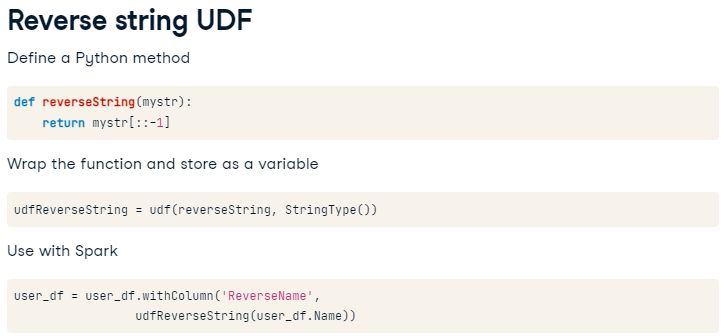
the function takes two arguments - the name of the method you just defined(reverseString), and the Spark data type it will return(StringType()).This can be any of the options in pyspark.sql.types, and can even be a more complex type, including a fully defined schema object. Most often, you'll return either a simple object type, or perhaps an ArrayType. 


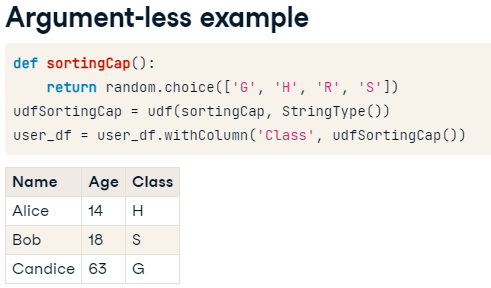
The primary difference is calling the function, this time without passing in an argument as it is not required.

## Using user defined functions in Spark
you're going to replace the first_name column with the first and middle names.<br>
* Edit the getFirstAndMiddle() function to return a space separated string of names, except the last entry in the names list.
* Define the function as a user-defined function. It should return a string type.
* Create a new column on voter_df called first_and_middle_name using your UDF.

In [25]:
from pyspark.sql.types import StringType

In [27]:
# Add a new column called splits separated on whitespace
voter_df = voter_df.withColumn("splits", F.split(voter_df.VOTER_NAME, '\s+'))

In [29]:
def getFirstAndMiddle(names):
  # Return a space separated string of names
  return ' '.join(names[:-1])

# Define the method as a UDF
udfFirstAndMiddle = F.udf(getFirstAndMiddle, StringType())

# Create a new column using your UDF
voter_df = voter_df.withColumn('first_and_middle_name', udfFirstAndMiddle(voter_df.splits))

# Drop the the columns of 'splits'
voter_df = voter_df.drop('splits')

# Show the DataFrame
voter_df.show()

+----------+-------------+-------------------+----------+---------+-------------------+---------------------+
|      DATE|        TITLE|         VOTER_NAME|first_name|last_name|         random_val|first_and_middle_name|
+----------+-------------+-------------------+----------+---------+-------------------+---------------------+
|02/08/2017|Councilmember|  Jennifer S. Gates|  Jennifer|    Gates| 0.5791334730797411|          Jennifer S.|
|02/08/2017|Councilmember| Philip T. Kingston|    Philip| Kingston| 0.7489520827659043|            Philip T.|
|02/08/2017|        Mayor|Michael S. Rawlings|   Michael| Rawlings|                2.0|           Michael S.|
|02/08/2017|Councilmember|       Adam Medrano|      Adam|  Medrano| 0.6761716085699515|                 Adam|
|02/08/2017|Councilmember|       Casey Thomas|     Casey|   Thomas| 0.5113842477363215|                Casey|
|02/08/2017|Councilmember|Carolyn King Arnold|   Carolyn|   Arnold| 0.6727574432332781|         Carolyn King|
|02/08/201

## Partitioning and lazy processing
### Partitioning
* DataFrames are broken up into partitions 
* Partition size can vary 
* Each partition is handled independently<br>
To check the number of partitions, use the method `.rdd.getNumPartitions()` on a DataFrame.
<br>

### Lazy processing
* Transformations are lazy 
 - `.withColumn(...)`,`.select(...)`,`.cache()`
* Nothing is actually done until an action is performed 
 - `.count()`,`.write(...)`,`.show()`
* Transformations can be re-ordered for best performance 
* Sometimes causes unexpected behavior<br>
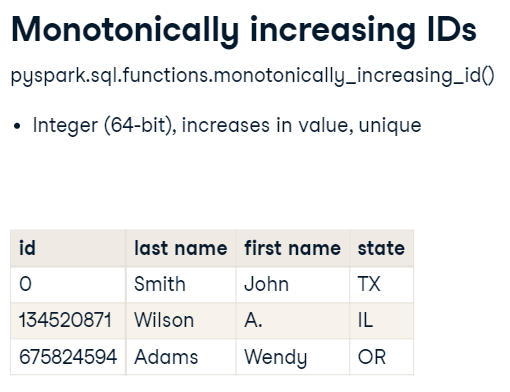<br>
`pyspark.sql.functions.monotonically_increasing_id()`

## Adding an ID Field
When working with data, you sometimes only want to access certain fields and perform various operations. In this case, find all the unique voter names from the DataFrame and add a unique ID number. Remember that Spark IDs are assigned based on the DataFrame partition - as such the ID values may be much greater than the actual number of rows in the DataFrame.

With Spark's lazy processing, the IDs are not actually generated until an action is performed and can be somewhat random depending on the size of the dataset.

In [53]:
# Load the CSV file
df = spark.read.format('csv').options(Header=True).load('DallasCouncilVotes.csv.gz')

In [54]:
# Select all the unique council voters
voter_df = df.select(df["VOTER NAME"]).distinct()

# Count the rows in voter_df
print("\nThere are %d rows in the voter_df DataFrame.\n" % voter_df.count())

# Add a ROW_ID
voter_df = voter_df.withColumn('ROW_ID', F.monotonically_increasing_id())

# Show the rows with 10 highest IDs in the set
voter_df.orderBy(voter_df.ROW_ID.desc()).show(10)


There are 36 rows in the voter_df DataFrame.

+--------------------+-------------+
|          VOTER NAME|       ROW_ID|
+--------------------+-------------+
|        Lee Kleinman|1709396983808|
|  the  final  201...|1700807049217|
|         Erik Wilson|1700807049216|
|  the  final   20...|1683627180032|
| Carolyn King Arnold|1632087572480|
| Rickey D.  Callahan|1597727834112|
|   the   final  2...|1443109011456|
|    Monica R. Alonzo|1382979469312|
|     Lee M. Kleinman|1228360646656|
|   Jennifer S. Gates|1194000908288|
+--------------------+-------------+
only showing top 10 rows



## IDs with different partitions
You've just completed adding an ID field to a DataFrame. Now, take a look at what happens when you do the same thing on DataFrames containing a different number of partitions.

To check the number of partitions, use the method `.rdd.getNumPartitions()` on a DataFrame.

In [55]:
voter_df_single = voter_df

In [60]:
# Load the CSV file
voter_df = spark.read.format('csv').options(Header=True).load('DallasCouncilVotes.csv.gz')
# Select all the unique council voters
voter_df = df.select(df["VOTER NAME"])

In [61]:
# Print the number of partitions in each DataFrame
print("\nThere are %d partitions in the voter_df DataFrame.\n" % voter_df.rdd.getNumPartitions())
print("\nThere are %d partitions in the voter_df_single DataFrame.\n" % voter_df_single.rdd.getNumPartitions())


There are 1 partitions in the voter_df DataFrame.


There are 200 partitions in the voter_df_single DataFrame.



In [62]:
# Add a ROW_ID field to each DataFrame
voter_df = voter_df.withColumn('ROW_ID', F.monotonically_increasing_id())
voter_df_single = voter_df_single.withColumn('ROW_ID', F.monotonically_increasing_id())

# Show the top 10 IDs in each DataFrame 
voter_df.orderBy(voter_df.ROW_ID.desc()).show(10)
voter_df_single.orderBy(voter_df_single.ROW_ID.desc()).show(10)

+-------------------+------+
|         VOTER NAME|ROW_ID|
+-------------------+------+
|      Mark  Clayton| 44624|
|     Tennell Atkins| 44623|
|       Kevin Felder| 44622|
|       Omar Narvaez| 44621|
|Rickey D.  Callahan| 44620|
|               null| 44619|
|  Casey  Thomas, II| 44618|
|       Adam Medrano| 44617|
|Michael S. Rawlings| 44616|
|Philip T.  Kingston| 44615|
+-------------------+------+
only showing top 10 rows

+--------------------+-------------+
|          VOTER NAME|       ROW_ID|
+--------------------+-------------+
|        Lee Kleinman|1709396983808|
|  the  final  201...|1700807049217|
|         Erik Wilson|1700807049216|
|  the  final   20...|1683627180032|
| Carolyn King Arnold|1632087572480|
| Rickey D.  Callahan|1597727834112|
|   the   final  2...|1443109011456|
|    Monica R. Alonzo|1382979469312|
|     Lee M. Kleinman|1228360646656|
|   Jennifer S. Gates|1194000908288|
+--------------------+-------------+
only showing top 10 rows



## More ID tricks
Once you define a Spark process, you'll likely want to use it many times. Depending on your needs, you may want to start your IDs at a certain value so there isn't overlap with previous runs of the Spark task. This behavior is similar to how IDs would behave in a relational database. You have been given the task to make sure that the IDs output from a monthly Spark task start at the highest value from the previous month.

In [ ]:
# Determine the highest ROW_ID and save it in previous_max_ID
previous_max_ID = voter_df_march.select('ROW_ID').rdd.max()[0]

# Add a ROW_ID column to voter_df_april starting at the desired value
voter_df_april = voter_df_april.withColumn('ROW_ID', previous_max_ID + F.monotonically_increasing_id())

# Show the ROW_ID from both DataFrames and compare
voter_df_march.select('ROW_ID').show()
voter_df_april.select('ROW_ID').show()

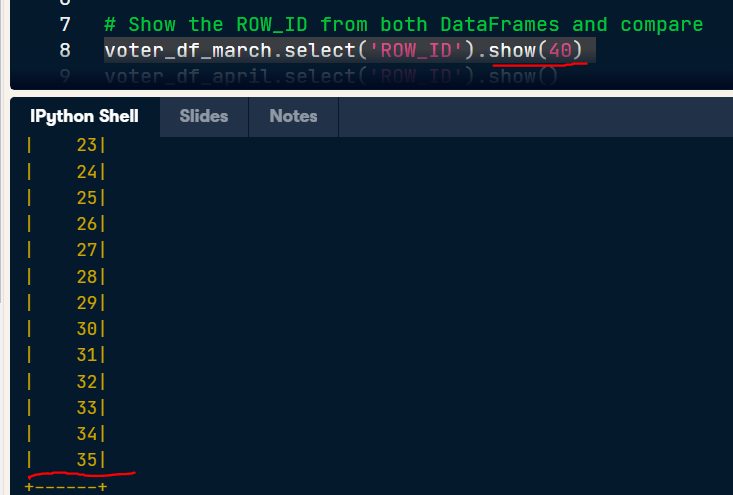

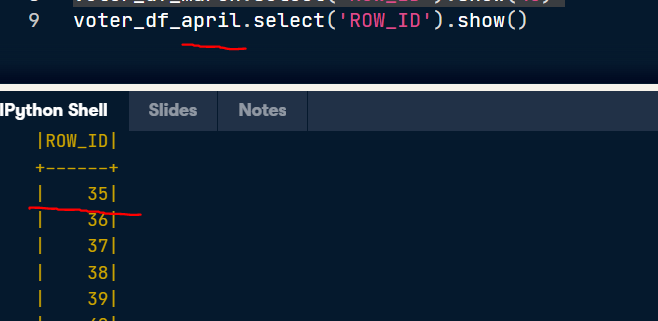

In [65]:
# Determine the highest ROW_ID and save it in previous_max_ID
previous_max_ID = voter_df_single.select('ROW_ID').rdd.max()[0]

# Add a ROW_ID column to voter_df_april starting at the desired value
voter_df = voter_df.withColumn('ROW_ID', previous_max_ID + F.monotonically_increasing_id())

# Show the ROW_ID from both DataFrames and compare
voter_df_single.select('ROW_ID').show()
voter_df.select('ROW_ID').show()

+-------------+
|       ROW_ID|
+-------------+
|   8589979216|
|  25769848400|
|  34359782992|
|  42949717584|
|  51539652176|
| 103079259728|
| 111669194320|
| 231928278608|
| 240518213200|
| 360777297488|
| 395137035856|
| 601295466064|
| 635655204432|
| 670014942800|
| 807453896272|
| 850403569232|
| 944892849744|
| 962072718928|
|1005022391888|
|1047972064848|
+-------------+
only showing top 20 rows

+-------------+
|       ROW_ID|
+-------------+
|1709397028432|
|1709397028433|
|1709397028434|
|1709397028435|
|1709397028436|
|1709397028437|
|1709397028438|
|1709397028439|
|1709397028440|
|1709397028441|
|1709397028442|
|1709397028443|
|1709397028444|
|1709397028445|
|1709397028446|
|1709397028447|
|1709397028448|
|1709397028449|
|1709397028450|
|1709397028451|
+-------------+
only showing top 20 rows



# 3.Improving Performance

## Caching
### Caching in Spark
* Stores DataFrames in memory or on disk 
* Improves speed on later transformations / actions 
* Reduces resource usage

### Disadvantages of caching
* Very large data sets may not 
* Local disk based caching may not be a performance improvement
* Cached objects may not be available

### Caching tips  
When developing Spark tasks:
* Cache only if you need it
* Try caching DataFrames at various points and determine if your performance improves 
* Cache in memory and fast SSD / NVMe storage 
* Cache to slow local disk if needed 
* Use intermediate 
```.cache()```, `.is_cached()`, `.unpersist()`
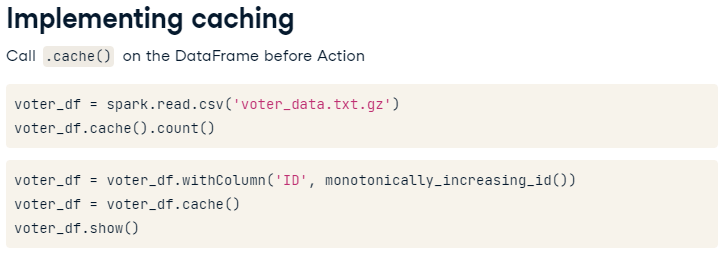

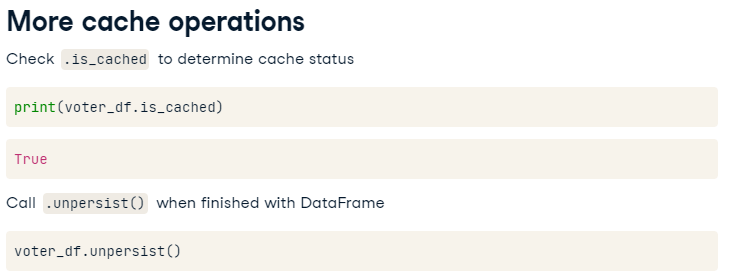

## Caching a DataFrame
You've been assigned a task that requires running several analysis operations on a DataFrame. You've learned that caching can improve performance when reusing DataFrames and would like to implement it.

You'll be working with a new dataset consisting of airline departure information. It may have repetitive data and will need to be de-duplicated.

In [73]:
# Load the CSV file
departures_df = spark.read.format('csv').options(Header=True).load('AA_DFW_2014_Departures_Short.csv.gz')

In [75]:
import time

In [77]:
start_time = time.time()

# Add caching to the unique rows in departures_df
departures_df = departures_df.distinct().cache()


# Count the unique rows in departures_df, noting how long the operation takes
print("Counting %d rows took %f seconds" % (departures_df.count(), time.time() - start_time))

# Count the rows again, noting the variance in time of a cached DataFrame
start_time = time.time()
print("Counting %d rows again took %f seconds" % (departures_df.count(), time.time() - start_time))

Counting 157198 rows took 3.759503 seconds
Counting 157198 rows again took 1.744603 seconds


## Removing a DataFrame from cache
You've finished the analysis tasks with the departures_df DataFrame, but have some other processing to do. You'd like to remove the DataFrame from the cache to prevent any excess memory usage on your cluster.

In [78]:
# Determine if departures_df is in the cache
print("Is departures_df cached?: %s" % departures_df.is_cached)
print("Removing departures_df from cache")

# Remove departures_df from the cache
departures_df.unpersist()

# Check the cache status again
print("Is departures_df cached?: %s" % departures_df.is_cached)

Is departures_df cached?: True
Removing departures_df from cache
Is departures_df cached?: False


## Improve import performance
### Spark clusters
Spark Clusters are made of two types of processes
* Driver process 
* Worker processes<br><br>
`one driver process` and as `many worker processes` as required. The `driver` handles task assignments and consolidation of the data results from the workers. The `workers` typically handle the actual transformation / action tasks of a Spark job. Once assigned tasks, they operate fairly independently and report results back to the driver. It is possible to have a single node Spark cluster but you'll rarely see this in a production environment. There are different ways to run Spark clusters - the method used depends on your specific environment.

### Import performance
Important parameters:
* Number of objects (Files, Network locations, etc)
 - More objects better than larger ones
 - Can import via wildcard
   `airport_df = spark.read.csv('airports-*.txt.gz')`
* General size of objects
 - Spark performs better if objects are of similar size

### Schemas
A well-dened schema will drastically improve import performance
* Avoids reading the data multiple times
* Provides validation on import

### How to split objects
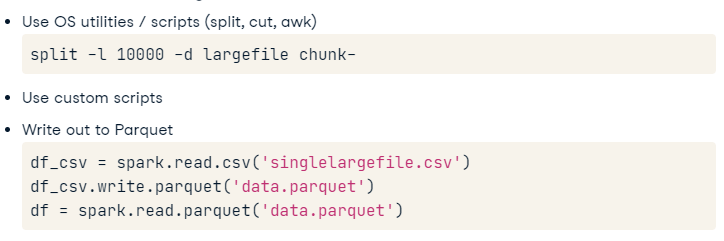

There are various effective ways to split an object (files mostly) into more smaller objects. 
* An example using split uses the `-l argument` with the number of lines to have per file (10000 in this case). The `-d argument` tells split to use numeric suffixes. The last two arguments are the name of the file to be split and the prefix to be used. Assuming 'largefile' has 10M records, we would have files named chunk-0000 through chunk-9999.每个文件100000行，字符，名字叫largefile，生成chunk0000开始

* Another method is to use python (or any other language) to split the objects up as we see fit. If you're going to be working with a DataFrame often, a simple method is to read in the single file then write it back out as parquet. 
* It's important to note that if you're hitting limitations due to cluster sizing, try to do as little processing as possible before writing to parquet.

## File import performance
You've been given a large set of data to import into a Spark DataFrame. You'd like to test the difference in import speed by splitting up the file.

You have two types of files available: `departures_full.txt.gz` and `departures_xxx.txt.gz` where **xxx is 000 - 013**. The same number of rows is split between each file.

In [ ]:
# Import the full and split files into DataFrames
full_df = spark.read.csv('departures_full.txt.gz')
split_df = spark.read.csv('departures_0*.txt.gz')

# Print the count and run time for each DataFrame
start_time_a = time.time()
print("Total rows in full DataFrame:\t%d" % full_df.count())
print("Time to run: %f" % (time.time() - start_time_a))

start_time_b = time.time()
print("Total rows in split DataFrame:\t%d" % split_df.count())
print("Time to run: %f" % (time.time() - start_time_b))

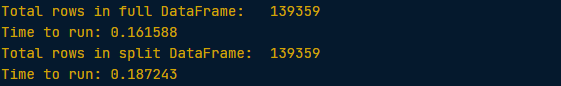

## Cluster configurations
### Configuration options
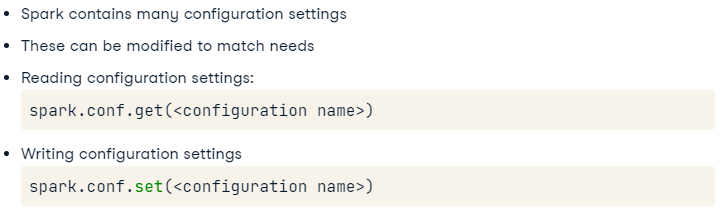
### Cluster Types
Spark deployment options: 
* Single node (deploying all components on a single system, can be physical/VM/container)
* Standalone (dedicated machines as the driver and workers)
* Managed (cluster components are handled by a third party cluster manager)
 - YARN 
 - Mesos 
 - Kubernetes
### Driver
* Task assignment 
* Result consolidation 
* Shared data access<br>
**Tips:** 
* Driver node should have double the memory of the worker 
* Fast local storage helpful
### Worker
* Runs actual tasks
* Ideally has all code, data, and resources for a given task<br>
**Recommendations:**
* More worker nodes is often better than larger workers
* Test to find the balance
* Fast local storage extremely useful

## Reading Spark configurations
You've recently configured a cluster via a cloud provider. Your only access is via the command shell or your python code. You'd like to verify some Spark settings to validate the configuration of the cluster.

In [80]:
# Name of the Spark application instance
app_name = spark.conf.get('spark.app.name')

# Driver TCP port
driver_tcp_port = spark.conf.get('spark.driver.port')

# Number of join partitions
num_partitions = spark.conf.get('spark.sql.shuffle.partitions')

# Show the results
print("Name: %s" % app_name)
print("Driver TCP port: %s" % driver_tcp_port)
print("Number of partitions: %s" % num_partitions)

Name: pyspark-shell
Driver TCP port: 49241
Number of partitions: 200


In [81]:
# Configure Spark to use 500 partitions
spark.conf.set('spark.sql.shuffle.partitions', 500)
# Number of join partitions

num_partitions_1 = spark.conf.get('spark.sql.shuffle.partitions')
print("Number of partitions: %s" % num_partitions_1)

Number of partitions: 500


## Writing Spark configurations
Now that you've reviewed some of the Spark configurations on your cluster, you want to modify some of the settings to tune Spark to your needs. You'll import some data to review that your changes have affected the cluster.

In [84]:
# Store the number of partitions in variable
before = departures_df.rdd.getNumPartitions()

# Configure Spark to use 500 partitions
spark.conf.set('spark.sql.shuffle.partitions', 300)

# Recreate the DataFrame using the departures data file
departures_df = spark.read.csv('AA_DFW_2015_Departures_Short.csv.gz').distinct()

# Print the number of partitions for each instance
print("Partition count before change: %d" % before)
print("Partition count after change: %d" % departures_df.rdd.getNumPartitions())

Partition count before change: 500
Partition count after change: 300


## Performance improvements
`.explain()`
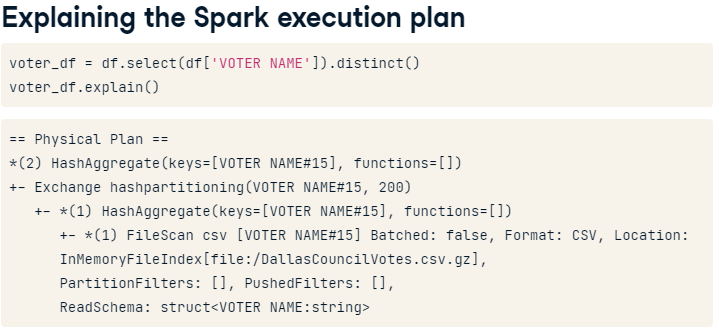

### Shuffling
Shufflling refers to moving data around to various workers to complete a task
* Hides complexity from the user
* Can be slow to complete
* Lowers overall throughput
* Is often necessary, but try to minimize
### How to limit shuffling
* Limit use of `.repartition(num_partitions)` 
 - Use `.coalesce(num_partitions)` instead
* Use care when calling `.join()`
* Use .broadcast()
* May not need to limit it

### Broadcasting
* Provides a copy of an object to each worker
* Prevents undue / excess communication between nodes 
* Can drastically speed up `.join()` operations
Use the `.broadcast(<DataFrame>)` method
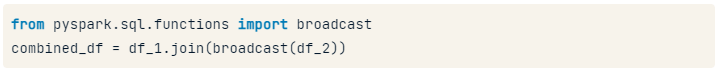

## Normal joins


In [ ]:
# Join the flights_df and aiports_df DataFrames
normal_df = flights_df.join(airports_df, \
    flights_df["Destination Airport"] == airports_df["IATA"] )

# Show the query plan
normal_df.explain()

In [ ]:
<script.py> output:
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [Destination Airport#18], [IATA#41], Inner
   :- Sort [Destination Airport#18 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(Destination Airport#18, 200), ENSURE_REQUIREMENTS, [id=#282]
   :     +- Filter isnotnull(Destination Airport#18)
   :        +- FileScan csv [Date (MM/DD/YYYY)#16,Flight Number#17,Destination Airport#18,Actual elapsed time (Minutes)#19] Batched: false, DataFilters: [isnotnull(Destination Airport#18)], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/tmp/tmpdsq2m6x1/AA_DFW_2018_Departures_Short.csv.gz], PartitionFilters: [], PushedFilters: [IsNotNull(Destination Airport)], ReadSchema: struct<Date (MM/DD/YYYY):string,Flight Number:string,Destination Airport:string,Actual elapsed ti...
   +- Sort [IATA#41 ASC NULLS FIRST], false, 0
      +- Exchange hashpartitioning(IATA#41, 200), ENSURE_REQUIREMENTS, [id=#283]
         +- Filter isnotnull(IATA#41)
            +- FileScan csv [AIRPORTNAME#40,IATA#41] Batched: false, DataFilters: [isnotnull(IATA#41)], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/tmp/tmpdsq2m6x1/airportnames.txt.gz], PartitionFilters: [], PushedFilters: [IsNotNull(IATA)], ReadSchema: struct<AIRPORTNAME:string,IATA:string>


## Using broadcasting on Spark joins
Remember that table joins in Spark are split between the cluster workers. If the data is not local, various shuffle operations are required and can have a negative impact on performance. Instead, we're going to use Spark's `broadcast` operations to give **each** node a copy of the specified data.

A couple tips:
* Broadcast the smaller DataFrame. The larger the DataFrame, the more time required to transfer to the worker nodes.
* On small DataFrames, it may be better skip broadcasting and let Spark figure out any optimization on its own.
* If you look at the query execution plan, a broadcastHashJoin indicates you've successfully configured broadcasting.

In [ ]:
# Import the broadcast method from pyspark.sql.functions
from pyspark.sql.functions import broadcast

# Join the flights_df and airports_df DataFrames using broadcasting
broadcast_df = flights_df.join(broadcast(airports_df), \
    flights_df["Destination Airport"] == airports_df["IATA"] )

# Show the query plan and compare against the original
broadcast_df.explain()

In [ ]:
<script.py> output:
    == Physical Plan ==
    AdaptiveSparkPlan isFinalPlan=false
    +- BroadcastHashJoin [Destination Airport#18], [IATA#41], Inner, BuildRight, false
       :- Filter isnotnull(Destination Airport#18)
       :  +- FileScan csv [Date (MM/DD/YYYY)#16,Flight Number#17,Destination Airport#18,Actual elapsed time (Minutes)#19] Batched: false, DataFilters: [isnotnull(Destination Airport#18)], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/tmp/tmpaht6_i_x/AA_DFW_2018_Departures_Short.csv.gz], PartitionFilters: [], PushedFilters: [IsNotNull(Destination Airport)], ReadSchema: struct<Date (MM/DD/YYYY):string,Flight Number:string,Destination Airport:string,Actual elapsed ti...
       +- BroadcastExchange HashedRelationBroadcastMode(List(input[1, string, false]),false), [id=#82]
          +- Filter isnotnull(IATA#41)
             +- FileScan csv [AIRPORTNAME#40,IATA#41] Batched: false, DataFilters: [isnotnull(IATA#41)], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/tmp/tmpaht6_i_x/airportnames.txt.gz], PartitionFilters: [], PushedFilters: [IsNotNull(IATA)], ReadSchema: struct<AIRPORTNAME:string,IATA:string>


## Comparing broadcast vs normal joins

In [ ]:
start_time = time.time()
# Count the number of rows in the normal DataFrame
normal_count = normal_df.count()
normal_duration = time.time() - start_time

start_time = time.time()
# Count the number of rows in the broadcast DataFrame
broadcast_count = broadcast_df.count()
broadcast_duration = time.time() - start_time

# Print the counts and the duration of the tests
print("Normal count:\t\t%d\tduration: %f" % (normal_count, normal_duration))
print("Broadcast count:\t%d\tduration: %f" % (broadcast_count, broadcast_duration))

<script.py> output:
    Normal count:		119910	duration: 0.750606
    Broadcast count:	119910	duration: 0.352258

# 4. Complex processing and data pipelines
## Introduction to data pipelines
### Data Pipelines
* Input(s):
  CSV, JSON, web services, databases 
* Transformations:
`withColumn()` , 
`.filter() `, 
`.drop()` 
* Output(s):
  CSV, Parquet, database 
* Validation
* Analysis
### Pipeline details
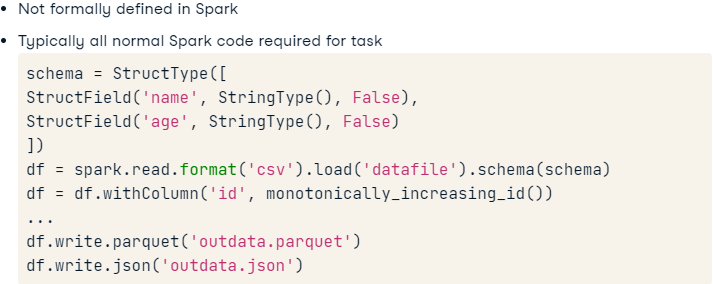

## Quick pipeline
Before you parse some more complex data, your manager would like to see a simple pipeline example including the basic steps. For this example, you'll want to ingest a data file, filter a few rows, add an ID column to it, then write it out as JSON data.

In [85]:
# Import the data to a DataFrame
departures_df = spark.read.csv('AA_DFW_2015_Departures_Short.csv.gz', header=True)

# Remove any duration of 0
departures_df = departures_df.filter(~ F.col('Actual elapsed time (Minutes)').contains('0'))
# or
# departures_df = departures_df.filter(~departures_df[3].contains('0'))

# Add an ID column
departures_df = departures_df.withColumn('id', F.monotonically_increasing_id())

# Write the file out to JSON format
departures_df.write.json('output.json', mode='overwrite')

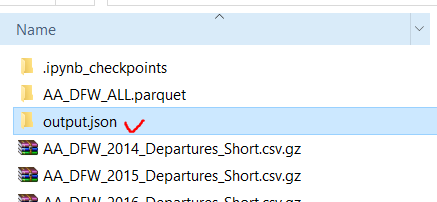

## Data handling techniques
### Parsing
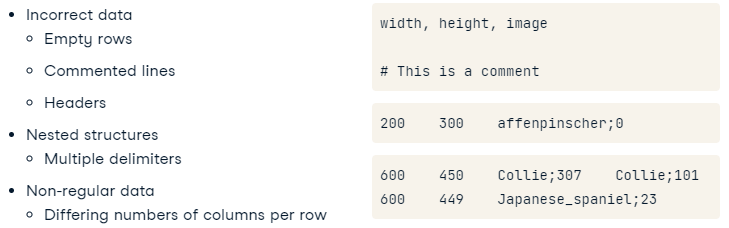
### Removing blank lines, headers, and comments
Spark's CSV parser:
* Automatically removes blank lines
* Can remove comments using an optional argument<br>
``df1 = spark.read.csv('datafile.csv.gz', comment='#') ``
* Handles header fields
 - Defined via argument
 - Ignored if a schema is defined<br>
``df1 = spark.read.csv('datafile.csv.gz', header='True')``

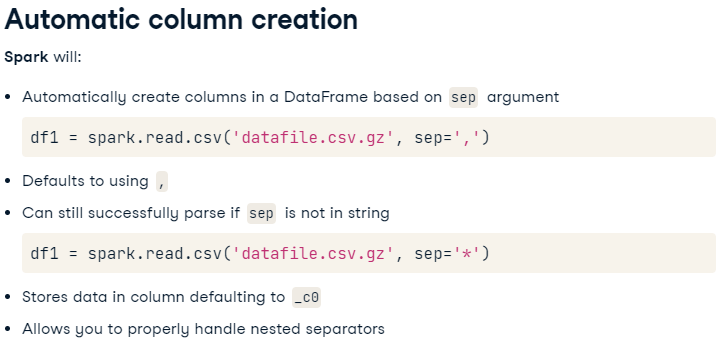

## Removing commented lines
Before any actual analysis can occur, you'll need to clear out several components of invalid / incorrect data. The general schema of the document is unknown so you'd like to import the rows into a single column, allowing for quick analysis.

* To start, you need to remove all commented rows in the dataset.

In [ ]:
annotations_df.show()
+--------------------+
|                 _c0|
+--------------------+
|025865917\tn02352...|
|022684404\tn02938...|
|021267273\tn02291...|
|02110627\tn021106...|
|02093754\tn020937...|
|%s\t%s\t800\t600\...|
|023200662\tn02305...|
|028666219\tn02573...|
|02104029\tn021040...|
|02111500\tn021115...|
|02104365\tn021043...|
|026860034\tn02293...|
|02105056\tn021050...|
|02093647\tn020936...|
|               # 339|
|02098413\tn020984...|
|02093859\tn020938...|
|02100583\tn021005...|
|023712701\tn02446...|
|               # 968|
+--------------------+
only showing top 20 rows

In [ ]:
# Import the file to a DataFrame and perform a row count
annotations_df = spark.read.csv('annotations.csv.gz', sep='|')
full_count = annotations_df.count()

# Count the number of rows beginning with '#'
comment_count = annotations_df.where(col('_c0').startswith('#')).count()

# Import the file to a new DataFrame, without commented rows
no_comments_df = spark.read.csv('annotations.csv.gz', sep='|', comment='#')

# Count the new DataFrame and verify the difference is as expected
no_comments_count = no_comments_df.count()
print("Full count: %d\nComment count: %d\nRemaining count: %d" % (full_count, comment_count, no_comments_count))

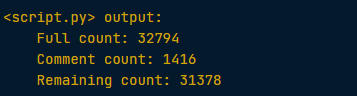

## Removing invalid rows
Now that you've successfully removed the commented rows, you have received some information about the general format of the data. There should be at minimum 5 tab separated columns in the DataFrame. Remember that your original DataFrame only has a single column, so you'll need to split the data on the tab `(\t)` characters.

In [ ]:
# Split _c0 on the tab character and store the list in a variable
tmp_fields = F.split(annotations_df['_c0'], '\t')

# Create the colcount column on the DataFrame representing the number of fields defined in the previous step
annotations_df = annotations_df.withColumn('colcount', F.size(tmp_fields))

# Remove any rows containing fewer than 5 fields
annotations_df_filtered = annotations_df.filter(~ (annotations_df["colcount"] < 5))

# Count the number of rows
final_count = annotations_df_filtered.count()
print("Initial count: %d\nFinal count: %d" % (initial_count, final_count))

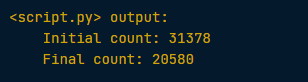

In [ ]:
+--------------------+--------+
|                 _c0|colcount|
+--------------------+--------+
|025865917\tn02352...|       2|
|022684404\tn02938...|       2|
|021267273\tn02291...|       2|
|02110627\tn021106...|       5|
|02093754\tn020937...|       5|
|%s\t%s\t800\t600\...|       5|
|023200662\tn02305...|       2|

## Splitting into columns
 Now you want to perform some further transformations by generating specific meaningful columns based on the DataFrame content.

In [ ]:
# Split the content of _c0 on the tab character (aka, '\t')
split_cols = F.split(annotations_df['_c0'], '\t')

# Add the columns folder, filename, width, and height
split_df = annotations_df.withColumn('folder', split_cols.getItem(0))
split_df = split_df.withColumn('filename', split_cols.getItem(1))
split_df = split_df.withColumn('width', split_cols.getItem(2))
split_df = split_df.withColumn('height', split_cols.getItem(3))

# Add split_cols as a column
split_df = split_df.withColumn('split_cols',split_cols)

In [ ]:
+--------------------+--------+--------+---------------+-----+------+--------------------+
|                 _c0|colcount|  folder|       filename|width|height|          split_cols|
+--------------------+--------+--------+---------------+-----+------+--------------------+
|02110627\tn021106...|       5|02110627|n02110627_12938|  200|   300|[02110627, n02110...|
|02093754\tn020937...|       5|02093754| n02093754_1148|  500|   378|[02093754, n02093...|
|%s\t%s\t800\t600\...|       5|      %s|             %s|  800|   600|[%s, %s, 800, 600...|
|02104029\tn021040...|       5|02104029|   n02104029_63|  500|   375|[02104029, n02104...|

## Further parsing
 You need to prep the column data for use in later analysis and remove a few intermediary columns.

In [ ]:
# Create a new function called retriever that takes two arguments, the split columns (cols) and the total number of columns (colcount). This function should return a list of the entries that have not been defined as columns yet (i.e., everything after item 4 in the list).
def retriever(cols, colcount):
  # Return a list of dog data
  return cols[4:colcount]

# Define the method as a UDF
udfRetriever = F.udf(retriever, ArrayType(StringType()))

# Create a new column using your UDF
split_df = split_df.withColumn('dog_list', udfRetriever(split_df.split_cols, split_df.colcount))

# Remove the original column, split_cols, and the colcount
split_df = split_df.drop('_c0').drop('colcount').drop('split_cols')

In [ ]:
+--------+---------------+-----+------+--------------------+
|  folder|       filename|width|height|            dog_list|
+--------+---------------+-----+------+--------------------+
|02110627|n02110627_12938|  200|   300|[affenpinscher,0,...|
|02093754| n02093754_1148|  500|   378|[Border_terrier,7...|
|      %s|             %s|  800|   600|[Shetland_sheepdo...|
|02104029|   n02104029_63|  500|   375|[kuvasz,0,0,499,327]|

## Data validation
### Validation is:
* Verifying that a dataset complies with the expected format 
* Number of rows / columns
* Data types
* Complex validation rules

### Validating via joins
* Compares data against known values 
* Easy to find data in a given set
* Comparatively fast
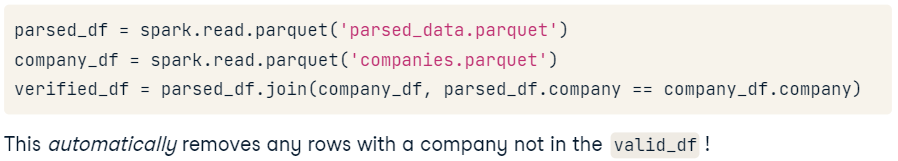

## Validate rows via join
Another example of filtering data is using joins to remove invalid entries. You'll need to verify the folder names are as expected based on a given DataFrame named `valid_folders_df`. The DataFrame `split_df` is as you last left it with a group of split columns.

In [ ]:
valid_folders_df.show()
+--------+
|     _c0|
+--------+
|02085620|
|02085782|
|02085936|
|02086079|

In [ ]:
# Rename the column in valid_folders_df
valid_folders_df = valid_folders_df.withColumnRenamed("_c0", "folder")

# Count the number of rows in split_df
split_count = split_df.count()

# Join the DataFrames,Make sure to broadcast the smaller DataFrame.
joined_df = split_df.join(F.broadcast (valid_folders_df), "folder")

# Compare the number of rows remaining
joined_count = joined_df.count()
print("Before: %d\nAfter: %d" % (split_count, joined_count))

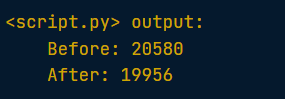

In [ ]:
joined_df.show()
+--------+---------------+-----+------+--------------------+
|  folder|       filename|width|height|            dog_list|
+--------+---------------+-----+------+--------------------+
|02110627|n02110627_12938|  200|   300|[affenpinscher,0,...|
|02093754| n02093754_1148|  500|   378|[Border_terrier,7...|
|02104029|   n02104029_63|  500|   375|[kuvasz,0,0,499,327]|
|02111500| n02111500_5137|  500|   375|[Great_Pyrenees,1...|
|02104365| n02104365_7518|  500|   333|[schipperke,146,2...|
|02105056| n02105056_2834|  500|   375|[groenendael,168,...|

## Examining invalid rows
You've successfully filtered out the rows using a join, but sometimes you'd like to examine the data that is invalid. This data can be stored for later processing or for troubleshooting your data sources.

You want to find the difference between two DataFrames and store the invalid rows.

In [ ]:
# Determine the row counts for each DataFrame
split_count = split_df.count()
joined_count = joined_df.count()

# Create a DataFrame containing the invalid rows
invalid_df = split_df.join(F.broadcast(joined_df), 'folder', 'left_anti')

# Validate the count of the new DataFrame is as expected
invalid_count = invalid_df.count()
print(" split_df:\t%d\n joined_df:\t%d\n invalid_df: \t%d" % (split_count, joined_count, invalid_count))

# Determine the number of distinct folder rows removed
invalid_folder_count = invalid_df.select('folder').distinct().count()
print("%d distinct invalid folders found" % invalid_folder_count)

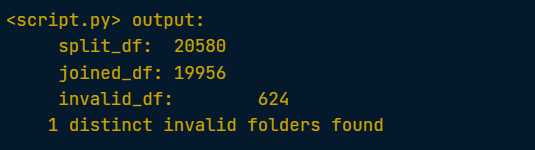

## Final analysis and delivery
### Analysis calculations (UDF)
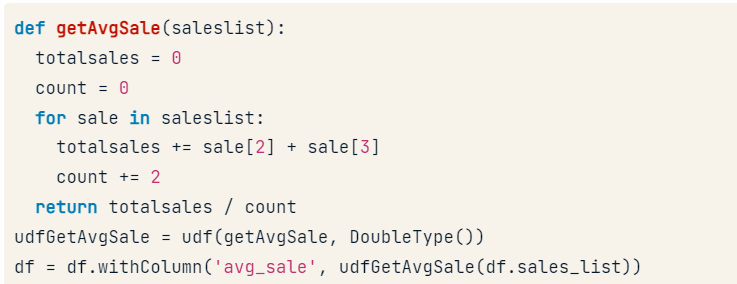

### Analysis calculations (inline)
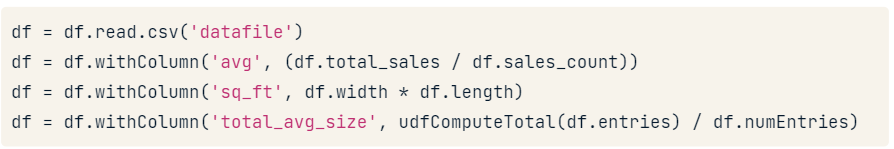

## Dog parsing
You've done a considerable amount of cleanup on the initial dataset, but now need to analyze the data a bit deeper. There are several questions that have now come up about the type of dogs seen in an image and some details regarding the images. You realize that to answer these questions, you need to process the data into a specific type. Before you can use it, you'll need to create a schema / type to represent the dog details.

In [ ]:
# Select the dog details and show 10 untruncated rows
print(joined_df.select('dog_list').show(10, truncate=False))

# Define a schema type for the details in the dog list
DogType = StructType([
    StructField("breed", StringType(), False),
    StructField("start_x", IntegerType(), False),
    StructField("start_y", IntegerType(), False),
    StructField("end_x", IntegerType(), False),
    StructField("end_x", IntegerType(), False)
])

In [ ]:
<script.py> output:
    +----------------------------------+
    |dog_list                          |
    +----------------------------------+
    |[affenpinscher,0,9,173,298]       |
    |[Border_terrier,73,127,341,335]   |
    |[kuvasz,0,0,499,327]              |
    |[Great_Pyrenees,124,225,403,374]  |
    |[schipperke,146,29,416,309]       |
    |[groenendael,168,0,469,374]       |

## Per image count
Your next task in building a data pipeline for this dataset is to create a few analysis oriented columns. You've been asked to calculate the number of dogs found in each image based on your `dog_list` column created earlier. You have also created the `DogType` which will allow better parsing of the data within some of the data columns.

In [ ]:
# Create a function to return the number and type of dogs as a tuple
def dogParse(doglist):
  dogs = []
  for dog in doglist:
    (breed, start_x, start_y, end_x, end_y) = dog.split(',')
    dogs.append((breed, int(start_x), int(start_y), int(end_x), int(end_y)))
  return dogs

# Create a UDF
udfDogParse = F.udf(dogParse, ArrayType(DogType))

# Use the UDF to list of dogs and drop the old column
joined_df = joined_df.withColumn('dogs', udfDogParse('dog_list')).drop('dog_list')

# Show the number of dogs in the first 10 rows
joined_df.select(F.size('dogs')).show(10)

In [ ]:
<script.py> output:
    +----------+
    |size(dogs)|
    +----------+
    |         1|
    |         1|
    |         1|
    |         1|

## Percentage dog pixels
The final task for parsing the dog annotation data is to determine the percentage of pixels in each image that represents a dog (or dogs). 
* To calculate the percentage of pixels, first calculate the total number of pixels representing each dog then sum them for the image. You can calculate the bounding box with the formula:

(Xend - Xstart) * (Yend - Ystart)

NOTE: You can ignore the possibility of overlapping bounding boxes in this instance.

For the percentage, calculate the total number of "dog" pixels divided by the total size of the image, multiplied by 100.

In [ ]:
# Define a UDF to determine the number of pixels per image
def dogPixelCount(doglist):
  totalpixels = 0
  for dog in doglist:
    totalpixels += (dog[3] - dog[1]) * (dog[4] - dog[2])
  return totalpixels

# Define a UDF for the pixel count
udfDogPixelCount = F.udf(dogPixelCount, IntegerType())
joined_df = joined_df.withColumn('dog_pixels', udfDogPixelCount('dogs'))

# Create a column representing the percentage of pixels
joined_df = joined_df.withColumn('dog_percent', (joined_df.dog_pixels / (joined_df.width * joined_df.height)) * 100)

# Show the first 10 annotations with more than 60% dog
joined_df.filter(joined_df['dog_percent'] > 60).show(10)
#joined_df.where('dog_percent > 60').show(10)

In [ ]:
<script.py> output:
    +--------+---------------+-----+------+--------------------+----------+-----------------+
    |  folder|       filename|width|height|                dogs|dog_pixels|      dog_percent|
    +--------+---------------+-----+------+--------------------+----------+-----------------+
    |02110627|n02110627_12938|  200|   300|[{affenpinscher, ...|     49997|83.32833333333333|
    |02104029|   n02104029_63|  500|   375|[{kuvasz, 0, 0, 4...|    163173|          87.0256|
    |02105056| n02105056_2834|  500|   375|[{groenendael, 16...|    112574|60.03946666666666|
    |02093647|  n02093647_541|  500|   333|[{Bedlington_terr...|    144640|86.87087087087087|
    |02098413| n02098413_1355|  500|   375|[{Lhasa, 39, 1, 4...|    171120|           91.264|